In [1]:
import sqlite3
import csv
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt


# Extract Data from Sqlite file 

In [62]:
def xtract_from_sql(db_name, path_to_sqlite):
    # Check if db_name starts with a number, if so, add 'sql_' to the start
    db_name = f"sql_{db_name}"
    db_name = db_name.replace('-', '_')

    # Connect to the SQLite database
    conn = sqlite3.connect(path_to_sqlite)
    cursor = conn.cursor()
    cursor.execute(f"DROP TABLE IF EXISTS {db_name}_extracted;")

    # Create a new table with the required columns
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {db_name}_extracted (
        attributes_accession TEXT,
        neighbors_accession TEXT,
        attributes_start INTEGER,
        attributes_stop INTEGER,
        seq_len INTEGER,
        cluster_num INTEGER,
        organism TEXT,
        family_desc TEXT,
        neighbors_start INTEGER,
        neighbors_stop INTEGER,
        a_direction TEXT,
        n_direction TEXT,
        nseq_len INTEGER,
        rel_start INTEGER,
        rel_stop INTEGER,
        a_family TEXT,
        alt_fam_desc TEXT,
        attributes_desc TEXT
    )
    """)

    # Insert required data from the 'attributes' and 'neighbors' tables
    cursor.execute(f"""
    INSERT INTO {db_name}_extracted (attributes_accession, neighbors_accession, attributes_start, attributes_stop, seq_len, cluster_num, organism, family_desc, neighbors_start, neighbors_stop, a_direction, n_direction, nseq_len, rel_start, rel_stop, a_family, alt_fam_desc, attributes_desc)
    SELECT a.accession, n.accession, a.start, a.stop, a.seq_len, a.cluster_num, a.organism, n.ipro_family_desc, n.start, n.stop, a.direction, n.direction, n.seq_len, n.rel_start, n.rel_stop, a.ipro_family, n.desc, a.desc
    FROM attributes a
    JOIN neighbors n
    ON a.sort_key = n.gene_key
    """)

    # Commit the changes
    conn.commit()

    # Fetch the data from the new table
    data_df = pd.read_sql_query(
        "SELECT * FROM " + db_name + "_extracted", conn)

    # Close the connection
    conn.close()

    return data_df



In [63]:

path_to_sqlite = '/Users/dirk/thesis_code/input_files/25655_96765_All_t7SS_shuttling_domains_21aln_repnode-.40_ssn_arrow_data_co10_ns5.sqlite'
db_name = os.path.basename(path_to_sqlite).split(".", 1)[0]

combo_df = xtract_from_sql(db_name, path_to_sqlite)
combo_df.to_csv('input_files/All_T7_gnn_neighb_acc_data.csv', index=False)

In [64]:
# Basic stats
print(len(combo_df))
print(combo_df.columns)

849806
Index(['attributes_accession', 'neighbors_accession', 'attributes_start',
       'attributes_stop', 'seq_len', 'cluster_num', 'organism', 'family_desc',
       'neighbors_start', 'neighbors_stop', 'a_direction', 'n_direction',
       'nseq_len', 'rel_start', 'rel_stop', 'a_family', 'alt_fam_desc',
       'attributes_desc'],
      dtype='object')


# Use combo_df to uncover neighbour patterns


In [65]:
combo_df['all_desc'] = combo_df['family_desc'] + ";" + combo_df['alt_fam_desc']
list_of_t7SS_terms = ["EssB", "EssA", "EssC", "YukD", "YukE", "DUF5082", "DUF5344", "DUF3130", "EsaA", "EsxA", "ESAT-6", "WXG100", "LXG", "EsaC", "TIGR04197", "Yxid", "YeeF", "DUF3958", "YueE", "FtsK/SpoIIIE", "EsaC", "EspG", "PE", "PPE", "PE-PGRS", "EspB", "EspK", "EccC", "EsxB", "CFP-10", "EccD", "EccE", "EsaD", "WXG100"] 

# count how many time DUF4176s are near other T7 genes 
combo_df['t7SS_postive'] = combo_df['all_desc'].str.contains('|'.join(list_of_t7SS_terms))
grouped_df = combo_df.groupby(['attributes_accession']).agg({'t7SS_postive': 'sum', 'all_desc': 'count'})
grouped_df['has_t7'] = grouped_df['t7SS_postive'] > 0
grouped_df['has_t7'].value_counts()
# grouped_df['has_t7'].value_counts(normalize=True)

True     20382
False     4644
Name: has_t7, dtype: int64

In [66]:
# Look at neighbords - Split by upstream and downstream genes

window = 3000
combo_df[f'within_{window}'] = (combo_df['rel_start'] > -3000) & (combo_df['rel_stop'] < 3000)
# combo_df['upstream'] = (combo_df['rel_start'] < 0) & (combo_df['rel_start'] > -window)
# combo_df['downstream'] = (combo_df['rel_start'] > 0) & (combo_df['rel_start'] < window)
list_of_t7SS_terms = ["EssB", "EssA", "EssC", "YukD", "YukE", "DUF5082", "DUF5344", "DUF3130", "EsaA", "EsxA", "ESAT-6", "WXG100", "LXG", "EsaC", "TIGR04197", "Yxid", "YeeF", "DUF3958", "YueE", "FtsK/SpoIIIE", "EsaC", "EspG", "PE", "PPE", "PE-PGRS", "EspB", "EspK", "EccC", "EsxB", "CFP-10", "EccD", "EccE", "EsaD", "WXG100"] 
within_3k_df = combo_df[combo_df[f'within_{window}'] == True]

def find_t7ss_genes(result_df, list_of_terms):
    # result_df['close_t7SS_postive'] = result_df['all_desc'].str.contains('|'.join(list_of_terms))
    result_df.loc[:, 'close_t7SS_postive'] = result_df['all_desc'].str.contains('|'.join(list_of_terms))
    for term in list_of_terms:
        result_df.loc[:,term] = result_df['all_desc'].str.contains(term)
    return result_df

new_combo_df = find_t7ss_genes(within_3k_df, list_of_t7SS_terms)
print(len(combo_df) - len(new_combo_df) )

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_60466/873669278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'close_t7SS_postive'] = result_df['all_desc'].str.contains('|'.join(list_of_terms))
/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_60466/873669278.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:,term] = result_df['all_desc'].str.contains(term)
/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_60466/873669278.py:14: SettingW

753945


/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_60466/873669278.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:,term] = result_df['all_desc'].str.contains(term)


In [67]:
# split the strings in the "all_desc" column on the semicolon delimiter
split_desc = new_combo_df['all_desc'].str.split(';')
# apply the split operation to each row of the DataFrame
split_desc = split_desc.apply(pd.Series).add_prefix('desc_')
# join the resulting list of strings into a new DataFrame with each string in its own column
desc_df = split_desc.add_prefix('desc_')
# concatenate the new DataFrame with the original DataFrame
result_df = pd.concat([new_combo_df, desc_df], axis=1)
# This is where search terms are defined
tdf = result_df[result_df.loc[:,'cluster_num'] <= 30]


In [70]:

print(len(tdf))
print(tdf.columns)
t_vcounts = tdf['cluster_num'].value_counts()
t_nvcounts = tdf['cluster_num'].value_counts(normalize=True)
vcounts = pd.DataFrame({'cluster_num': t_vcounts.index, 'counts': t_vcounts, 'percent': t_nvcounts})

tdf.loc[:,['cluster_num', 'neighbors_accession', 'attributes_desc']]


90289
Index(['attributes_accession', 'neighbors_accession', 'attributes_start',
       'attributes_stop', 'seq_len', 'cluster_num', 'organism', 'family_desc',
       'neighbors_start', 'neighbors_stop', 'a_direction', 'n_direction',
       'nseq_len', 'rel_start', 'rel_stop', 'a_family', 'alt_fam_desc',
       'attributes_desc', 'all_desc', 't7SS_postive', 'within_3000',
       'close_t7SS_postive', 'EssB', 'EssA', 'EssC', 'YukD', 'YukE', 'DUF5082',
       'DUF5344', 'DUF3130', 'EsaA', 'EsxA', 'ESAT-6', 'WXG100', 'LXG', 'EsaC',
       'TIGR04197', 'Yxid', 'YeeF', 'DUF3958', 'YueE', 'FtsK/SpoIIIE', 'EspG',
       'PE', 'PPE', 'PE-PGRS', 'EspB', 'EspK', 'EccC', 'EsxB', 'CFP-10',
       'EccD', 'EccE', 'EsaD', 'desc_desc_0', 'desc_desc_1', 'desc_desc_2',
       'desc_desc_3', 'desc_desc_4', 'desc_desc_5', 'desc_desc_6',
       'desc_desc_7', 'desc_desc_8', 'desc_desc_9', 'desc_desc_10',
       'desc_desc_11', 'desc_desc_12', 'desc_desc_13', 'desc_desc_14'],
      dtype='object')


,cluster_num,neighbors_accession,attributes_desc
19,1,A0A024JQD1,PPE family protein
20,1,A0A024JQ74,PPE family protein
57,1,A0A024JQ72,PPE family protein
58,1,A0A024JQX9,PPE family protein
59,1,A0A024JRB0,PPE family protein
...,...,...,...
803052,30,X7VDP5,PPE family protein
803053,30,X7VFM9,PPE family protein
803054,30,X7VEL9,PPE family protein
803055,30,X7VD98,PPE family protein


In [126]:
agg_dict = {term : 'any' for term in list_of_t7SS_terms}
agg_dict['neighbors_accession'] = 'count'
agg_dict['cluster_num'] = 'first'
agg_dict['attributes_desc'] = 'first'
grouped_top_df = tdf.groupby(['attributes_accession']).agg(agg_dict)
list_of_secreted = ["EsxA", "ESAT-6", "WXG100", "LXG", "PE", "PPE", "PE-PGRS", "EspB", "EsxB", "CFP-10"] 

for term in list_of_secreted:
    term_match = grouped_top_df['attributes_desc'].str.contains(r'\b{}\b'.format(term))
    grouped_top_df.loc[:,f'is_{term}'] = term_match

# print(grouped_top_df.value_counts()) 
fam_columns = [f'is_{term}' for term in list_of_secreted]
fams = grouped_top_df[fam_columns]
fams['attribute_fam_master'] = fams.apply(lambda row: ' ... '.join(row.index[row]), axis=1)

split_df = fams['attribute_fam_master'].str.split(' ... ', expand=True)
split_df = split_df.add_prefix('fam_')

fam_detailed = pd.concat([grouped_top_df, split_df], axis=1)

fam_detailed['fam_0'] = fam_detailed['fam_0'].str.replace('is_', '')
fam_detailed['fam_1'] = fam_detailed['fam_1'].str.replace('is_', '')


grouped_top_df['main_att_fam'] = fam_detailed['fam_0']
grouped_top_df




/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_60466/3724085009.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fams['attribute_fam_master'] = fams.apply(lambda row: ' ... '.join(row.index[row]), axis=1)


,EssB,EssA,EssC,YukD,YukE,DUF5082,DUF5344,DUF3130,EsaA,EsxA,...,is_ESAT-6,is_WXG100,is_LXG,is_PE,is_PPE,is_PE-PGRS,is_EspB,is_EsxB,is_CFP-10,main_att_fam
attributes_accession,,,,,,,,,,,,,,,,,,,,,
A0A014MA45,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,WXG100
A0A022NGB8,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,LXG
A0A023CP67,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,
A0A023P1Z4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,LXG
A0A023P6I3,False,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,False,LXG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X8FLS6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,PPE
X8FM77,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,PPE
X8FP01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,PPE


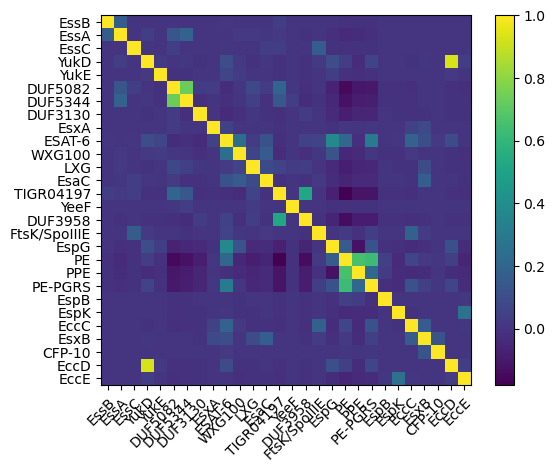

In [48]:
mat_df = grouped_top_df.drop(columns=['EsaD','EsaA', 'Yxid', 'YueE','cluster_num', 'neighbors_accession'])

# Compute the correlation between columns
corr_matrix = mat_df.corr()

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Display the correlation matrix as an image
im = ax.imshow(corr_matrix)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()

In [ ]:


# top_result_df = result_df.loc[result_df['cluster_num'] < 19]

grouped_top_df = tdf.groupby(['attributes_accession']).agg({'close_t7SS_postive': 'any', 'LXG_positive': 'any', 'WXG100_positive': 'any', 'DUF5082_positive': 'any', 'DUF443_positive': 'any', 'Lap1/3_positive' : 'any', 'DUF3958_positive' : 'any', 'Second_DUF4176_positive' : 'any' , 'all_desc': 'count', 'cluster_num': 'first'})
grouped_result_df = result_df.groupby(['attributes_accession', 'cluster_num']).agg({'close_t7SS_postive': 'any', 'LXG_positive': 'any', 'WXG100_positive': 'any', 'DUF5082_positive': 'any', 'Lap1/3_positive' : 'any', 'DUF443_positive': 'any', 'DUF3958_positive' : 'any', 'Second_DUF4176_positive' : 'any' , 'all_desc': 'count', 'cluster_num': 'first'})


print(f'Size of total dataset: {len(grouped_result_df)}')
print(f'Size top 18 clusters dataset: {len(grouped_top_df)}')
print(f'Top set coverage {len(grouped_top_df)/len(grouped_result_df) * 100}%')
print('\n-----\nGenes within +/- 6000bp')
print('\nAny T7SS')
print(grouped_top_df['close_t7SS_postive'].value_counts(normalize=True))
print('\nLXG_positive')
print(grouped_top_df['LXG_positive'].value_counts(normalize=True))
print('\nLap1/3_positive') 
print(grouped_top_df['Lap1/3_positive'].value_counts(normalize=True))
print('\nDUF5082_positive')
print(grouped_top_df['DUF5082_positive'].value_counts(normalize=True))
print('\nWXG100_positive')
print(grouped_top_df['WXG100_positive'].value_counts(normalize=True))
print('\nDUF443_positive')
print(grouped_top_df['DUF443_positive'].value_counts(normalize=True))
print('\nDUF3958_positive')
print(grouped_top_df['DUF3958_positive'].value_counts(normalize=True))
print('\nSecond_DUF4176_positive')
print(grouped_top_df['Second_DUF4176_positive'].value_counts(normalize=True))


In [17]:
type_1 = [grouped_result_df['LXG_positive'], grouped_result_df['DUF5082_positive'], grouped_result_df['Lap1/3_positive']]
type_2 = [grouped_result_df['DUF443_positive'], grouped_result_df['DUF3958_positive'], grouped_result_df['Lap1/3_positive']]
type_3 = [grouped_result_df['Second_DUF4176_positive'], grouped_result_df['DUF3958_positive'], grouped_result_df['Lap1/3_positive']]
type_4 = [grouped_result_df['WXG100_positive'], grouped_result_df['Second_DUF4176_positive']]
type_6 = [grouped_result_df['WXG100_positive'], grouped_result_df['LXG_positive'], grouped_result_df['DUF5082_positive'], grouped_result_df['DUF5082_positive']]
grouped_result_df['Type 1 score'] = round((sum(type_1)/len(type_1))*10)
grouped_result_df['Type 2 score'] = round((sum(type_2)/len(type_2))*10)
grouped_result_df['Type 3 score'] = round((sum(type_3)/len(type_3))*10)
grouped_result_df['Type 4 score'] = round((sum(type_4)/len(type_4))*10)
grouped_result_df['Type 6 score'] = round((sum(type_6)/len(type_6))*10)

grouped_result_df['dominant type'] = grouped_result_df[['Type 1 score', 'Type 2 score', 'Type 3 score', 'Type 4 score', 'Type 6 score']].idxmax(axis=1)
# , grouped_result_df['Second_DUF4176_positive'] grouped_result_df['WXG100_positive'], , grouped_result_df['DUF443_positive'], , grouped_result_df['DUF3958_positive']
grouped_result_df.value_counts('dominant type')



dominant type
Type 1 score    950
Type 4 score    679
Type 6 score    183
Type 2 score     83
Type 3 score      8
dtype: int64

In [ ]:

new_combo_df = new_combo_df[new_combo_df['cluster_num'] < 19]

up_genes = new_combo_df[new_combo_df['upstream'] == True]
down_genes = new_combo_df[new_combo_df['downstream'] == True]

upstream_g = up_genes.groupby(['attributes_accession']).agg({ 'LXG': 'any', 'WXG100': 'any', 'DUF5082': 'any', 'DUF443': 'any', 'Lap1/3' : 'any', 'DUF3958' : 'any', 'Second_DUF4176' : 'any' }).add_prefix('up_')
downstream_g = down_genes.groupby(['attributes_accession']).agg({ 'LXG': 'any', 'WXG100': 'any', 'DUF5082': 'any', 'DUF443': 'any', 'Lap1/3' : 'any', 'DUF3958' : 'any', 'Second_DUF4176' : 'any' }).add_prefix('down_')

up_down = pd.merge(upstream_g, downstream_g, on='attributes_accession', how='inner')
# print(len(upstream_g))
# print(len(downstream_g))
# print(len(up_down))

true_cols = up_down.apply(lambda x: list(x.index[x]), axis=1)
up_down['true_cols'] = true_cols

pd.set_option('display.max_rows', None)
up_down['true_cols'].value_counts()



# By cluster - make heatmap to survey operon architectures 


In [8]:
by_cluster = grouped_top_df.groupby('cluster_num').agg({ 'LXG_positive': 'sum', 'DUF5082_positive': 'sum', 'DUF3958_positive' : 'sum', 'Lap1/3_positive': 'sum', 'DUF443_positive': 'sum', 'Second_DUF4176_positive' : 'sum',  'WXG100_positive': 'sum',     'cluster_num' : 'count'})
by_cluster.rename(columns={'LXG_positive': 'LXG', 'DUF5082_positive': 'Lap4', 'DUF3958_positive' : 'Lap2', 'Lap1/3_positive': 'Lap1/3', 'DUF443_positive': 'TipD', 'Second_DUF4176_positive' : 'DUF4176',  'WXG100_positive': 'EsxA-like'}, inplace=True)

cluster_counts = by_cluster['cluster_num']
ratio_df = by_cluster.div(cluster_counts, axis=0)
percent_df = round(ratio_df * 100, 1)
percent_df.drop(columns=['cluster_num'], inplace=True)



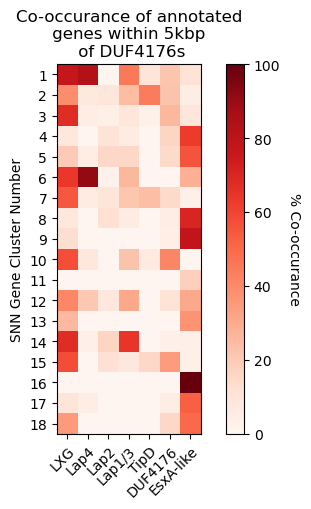

In [9]:
import matplotlib.pyplot as plt

# create a heatmap plot of percent_df
fig, ax = plt.subplots()
im = ax.imshow(percent_df, cmap='Reds')

# set the x-axis and y-axis labels
ax.set_xticks(range(len(percent_df.columns)))
ax.set_yticks(range(len(percent_df.index)))
ax.set_xticklabels(percent_df.columns)
ax.set_yticklabels(percent_df.index)

# rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('SNN Gene Cluster Number')

# add the colorbar
cbar = ax.figure.colorbar(im, ax=ax) 
cbar.set_label('% Co-occurance', rotation=270, labelpad=15)
# set the title
ax.set_title('Co-occurance of annotated\n genes within 5kbp \n of DUF4176s')
plt.savefig('heatmap/heatmap.svg', format='svg', dpi=1200)
# show the plot
plt.show()


# Read in uniprot data df 

Download the excel file directly from Uniprot
Data was processed and cleaned up a bit in the DUF_4176 basic overview notebook 

,attributes_accession,neighbors_accession,attributes_start,attributes_stop,seq_len,cluster_num,organism,family_desc,neighbors_start,neighbors_stop,...,desc_desc_11,desc_desc_12,desc_desc_13,LXG_positive,WXG100_positive,DUF5082_positive,Lap1/3_positive,DUF443_positive,DUF3958_positive,Second_DUF4176_positive
5,A0A060RLE7,A0A060RJ66,20161,20823,219,1,Streptococcus gallolyticus.,DUF5082,19452,19868,...,NaN,NaN,NaN,False,False,True,False,False,False,False
6,A0A060RLE7,A0A060RIH7,20161,20823,219,1,Streptococcus gallolyticus.,,19880,20161,...,NaN,NaN,NaN,False,False,False,True,False,False,False
7,A0A060RLE7,A0A060RLJ5,20161,20823,219,1,Streptococcus gallolyticus.,LXG_dom,20813,22408,...,NaN,NaN,NaN,True,False,False,False,False,False,False
36,A0A069CRX2,A0A069CRZ9,236912,237631,238,1,Weissella oryzae (strain DSM 25784 / JCM 18191...,,234686,235075,...,NaN,NaN,NaN,False,False,False,False,False,False,False
37,A0A069CRX2,A0A069CSC0,236912,237631,238,1,Weissella oryzae (strain DSM 25784 / JCM 18191...,LXG_dom,235075,236910,...,NaN,NaN,NaN,True,False,False,False,False,False,False


# Sunburst diagram of firmicutes genes

In [53]:
import plotly.express as px
import numpy as np
import seaborn as sns

# create a color palette based on the "family" column
# get a list of unique values in the "family" column
unique_families = cdf['family'].unique()
# set the color palette to use 3-digit RGB values

family_counts = cdf['family'].value_counts()
    
# # combine categories with an occurrence below 5% into a new category called "other"
# other_count = family_counts[family_counts < 0.05 * family_counts.sum()].sum()
# family_counts = family_counts[family_counts >= 0.05 * family_counts.sum()]
# family_counts['other'] = other_count

# combine categories with an occurrence below 1.5% into a new category called "other"
other_count = family_counts[family_counts < 0.01 * family_counts.sum()].sum()
family_counts = family_counts[family_counts >= 0.01 * family_counts.sum()]
family_counts['other'] = other_count
# create a pie chart for the current cluster using the colors from the "family_colors" dictionary

# create a list of colors based on the "colorblind" color palette
palette_list = sns.color_palette('colorblind', n_colors=len(family_counts.index), as_cmap=True)
palette_list = palette_list * (len(family_counts.index) // len(palette_list) + 1)

# create a dictionary that maps each unique family to a specific color in the "husl" color palette
family_colors = {family: palette_list[i] for i, family in enumerate(family_counts.index)}
family_colors['other'] = 'gray'


# create a list of colors based on the "husl" color palette
palette_list = sns.color_palette('colorblind', n_colors=len(family_counts), as_cmap=True)
palette_list = palette_list * (len(family_counts.index) // len(palette_list) + 1)

# create a dictionary that maps each unique family to a specific color in the "husl" color palette
family_colors = {family: palette_list[i] for i, family in enumerate(family_counts.index)}
# family_colors['other'] = 'gray'
path=['phylum', 'class', 'order', 'family', 'species']
fig = px.sunburst(cdf, path=path, 
                  values=cdf.index,
                  color='family',
                  color_discrete_map=family_colors,
                  branchvalues='total')
                  
                #   color_continuous_midpoint = 125)
                #   color_continuous_midpoint=np.average(cdf['seq_len'], weights=cdf.index))


# show the diagram
fig.show()
fig.write_image('sunburst/sunburst2.svg', format='svg')

# Plot Lengths historgram 

# Retreive records from uniprot database 

In [179]:

# group the data by cluster_num and count the number of members in each group
group_counts = atrib_df.groupby('cluster_num').size()

# get the cluster numbers with more than 5 members
large_clusters = group_counts[group_counts > 19].index.tolist()

# create a subset of atrib_df that only contains rows from large clusters
large_cluster_df = atrib_df.groupby('cluster_num').filter(lambda x: x.name in large_clusters)


/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_66537/2730234891.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_66537/2730234891.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_66537/2730234891.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_66537/2730234891.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 

/var/folders/8v/vvcy5rtx1pd33q_5wmhd058w0000gn/T/ipykernel_66537/2730234891.py:24: UserWarning:

Tight layout not applied. The left 

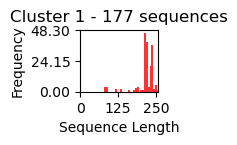

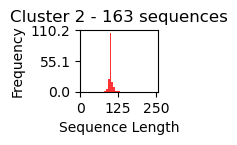

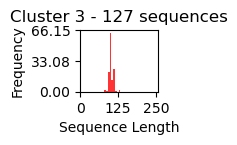

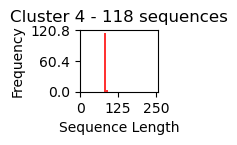

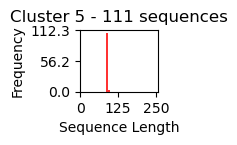

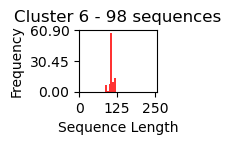

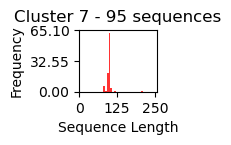

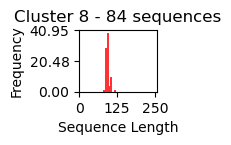

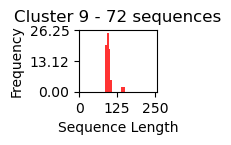

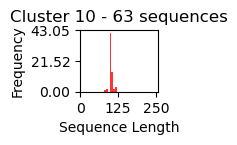

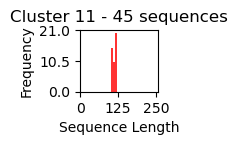

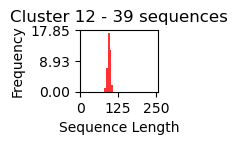

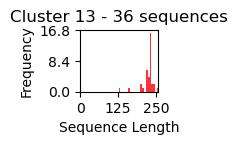

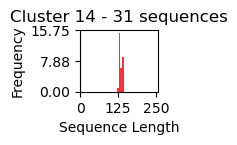

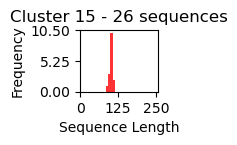

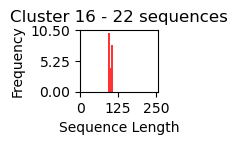

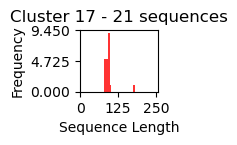

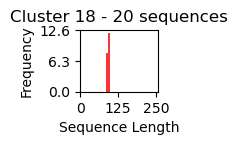

In [180]:
import numpy as np

# calculate the bin edges based on the maximum and minimum values of the data and the desired bin width
bin_width = 6
min_seq_len = large_cluster_df['seq_len'].min()
max_seq_len = large_cluster_df['seq_len'].max()
bins = np.arange(min_seq_len, max_seq_len + bin_width, bin_width)

# group the data by cluster_num
groups = large_cluster_df.groupby('cluster_num')

# plot a histogram for each group
for name, group in groups:
    fig, ax = plt.subplots(figsize=(1, 0.8))
    group.hist(column='seq_len', bins=bins, color='red', alpha=0.8, ax=ax)
    
    ax.set_title(f'Cluster {name} - {len(group)} sequences')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, max_seq_len)
    ax.set_xticks([0, 125, 250])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 3))
    ax.grid(False)  # turn off the grid lines
    plt.tight_layout()
    plt.savefig(f'plots_histograms/frequency_cluster_{name}.svg')
    # plt.show()
    # print(f'Cluster {name} has {len(group)} members')

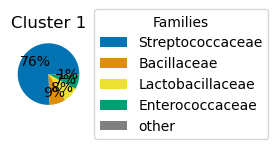

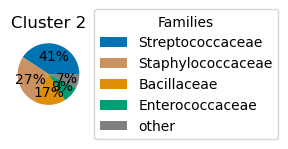

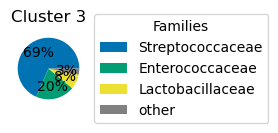

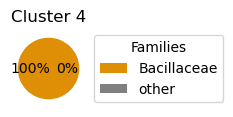

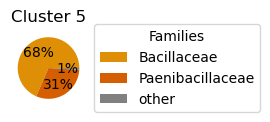

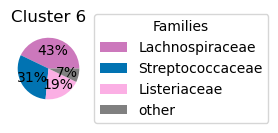

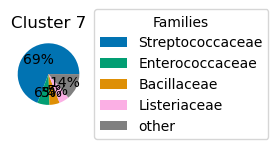

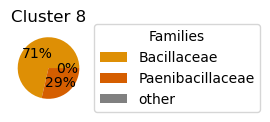

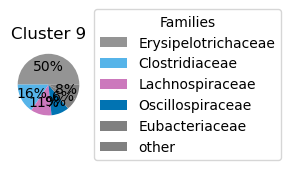

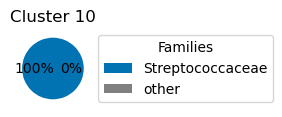

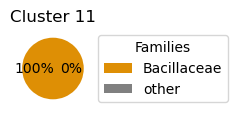

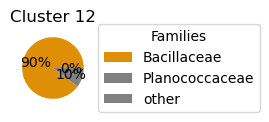

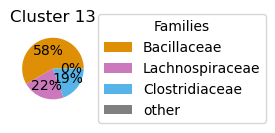

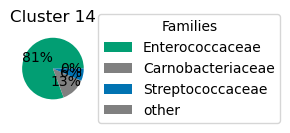

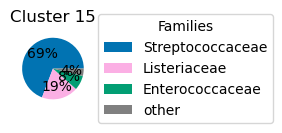

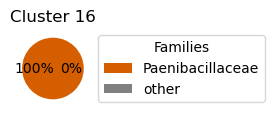

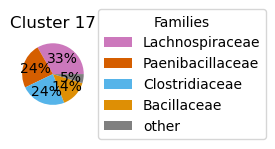

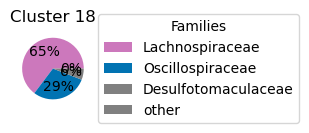

In [93]:
import seaborn as sns

# create a color palette based on the "family" column
# get a list of unique values in the "family" column
# unique_families = final_table['family'].unique()

family_counts = final_table['family'].value_counts()
    
# combine categories with an occurrence below 1.5% into a new category called "other"
other_count = family_counts[family_counts < 0.01 * family_counts.sum()].sum()
family_counts = family_counts[family_counts >= 0.01 * family_counts.sum()]
family_counts['other'] = other_count
# create a pie chart for the current cluster using the colors from the "family_colors" dictionary

# create a list of colors based on the "colorblind" color palette
palette_list = sns.color_palette('colorblind', n_colors=len(family_counts.index), as_cmap=True)
palette_list = palette_list * (len(family_counts.index) // len(palette_list) + 1)

# create a dictionary that maps each unique family to a specific color in the "husl" color palette
family_colors = {family: palette_list[i] for i, family in enumerate(family_counts.index)}
family_colors['other'] = 'gray'


# colors = [family_colors[family] for family in family_counts.index]

# loop over each cluster and create a pie chart for the values of "family"
for i, cluster_num in enumerate(final_table['cluster_num'].unique()):
    # create a new dataframe that counts the number of occurrences of each family in the current cluster
    cluster_df = final_table[final_table['cluster_num'] == cluster_num]
    family_data = cluster_df['family'].value_counts()
    # Group families with less than 5% occurrence into 'other'
    other_count = family_data[family_data < 0.05 * family_data.sum()].sum()
    family_data = family_data[family_data >= 0.05 * family_data.sum()]
    family_data['other'] = other_count
    
    
    # generate a list of colors for families in the current cluster
    colors = [family_colors.get(family, 'gray') for family in family_data.index]

    # create a new figure and axis object for the current cluster
    fig, ax = plt.subplots(figsize=(1, 1))
    
    wedges, labels, _ = ax.pie(family_data, colors=colors, autopct='%1.0f%%')

    # add a legend to the pie chart
    ax.legend(wedges, family_data.index, title='Families', loc='center left', bbox_to_anchor=(1, 0.5))

    # set the label font size to 8 points
    plt.setp(labels, fontsize=8)
    
    
    ax.set_title(f'Cluster {cluster_num}')
    plt.savefig(f'plots_pie/family_cluster_{cluster_num}.svg')
    # show the plot
    # plt.show()

# Generate MSA from sequence data 
- Sample dataset proportionally 
- write out sequences + accessions to fasta files 
- Run MUSCLE on dataset 
- run fasttree 

In [116]:
# Sample dataset 

def sample_and_search(df, min_cluster_size=19, prop_size=750, max_size=100):
    '''
    use to reduce size of final_table to a more manageable size, target is 500 rows but it will depend on how varied the data is
    Cutoff of max size is 200 rows, otherwise the tree is overwhemed
    '''
    # Tabulate the count of each unique cluster number
    cluster_counts = df['cluster_num'].value_counts()
    count_total = cluster_counts.sum()
    # print(f"Clusters: \n {cluster_counts.head(15)}")
    # normalize dataset to 500 rows by default
    norm_factor = prop_size / count_total

    # Sample rows by cluster, proportional to the number of rows in each cluster
    sampled_rows = []
    for cluster_num, count in cluster_counts.items():
        # If the number of rows in a cluster is less than min (set in function header), don't sample

        if count < min_cluster_size:
            continue

        # Calculate the sample size based on the normalized count
        # You can adjust the factor (e.g., 100 for proportions to represent %) to control the sample size
        sample_size = int((norm_factor) * count)
        # Prevent tiny useless datasets
        if sample_size < 10:
            sample_size = 10
        # prevent oversampling from drowning data - beware 
        if sample_size > max_size:
            sample_size = max_size
        # Ensure that the sample size is at least 1
        sample_size = max(1, sample_size)
        print(
            f'count: {count}, count_total: {count_total}, sample_size: {sample_size}')
        # Sample rows from the current cluster
        cluster_sample = df[df['cluster_num']
                            == cluster_num].sample(sample_size)

        # Append the sampled rows to the list
        sampled_rows.extend(cluster_sample.to_dict("records"))
    # build dataframe from sampled rows
    sampled_df = pd.DataFrame(sampled_rows)

    # # Write out dataframes
    # sampled_df.to_csv(f"{csv_name}_proportional_sample.csv", index=False)
    
    return sampled_df
sampled_df = sample_and_search(final_table)


count: 177, count_total: 1348, sample_size: 98
count: 163, count_total: 1348, sample_size: 90
count: 127, count_total: 1348, sample_size: 70
count: 118, count_total: 1348, sample_size: 65
count: 111, count_total: 1348, sample_size: 61
count: 98, count_total: 1348, sample_size: 54
count: 95, count_total: 1348, sample_size: 52
count: 84, count_total: 1348, sample_size: 46
count: 72, count_total: 1348, sample_size: 40
count: 63, count_total: 1348, sample_size: 35
count: 45, count_total: 1348, sample_size: 25
count: 39, count_total: 1348, sample_size: 21
count: 36, count_total: 1348, sample_size: 20
count: 31, count_total: 1348, sample_size: 17
count: 26, count_total: 1348, sample_size: 14
count: 22, count_total: 1348, sample_size: 12
count: 21, count_total: 1348, sample_size: 11
count: 20, count_total: 1348, sample_size: 11


,accession,seq_len,organism,cluster_num,sequence,gene_id,caution,kingdom,phylum,class,order,family,genus
0,A0A242LL22,235,Enterococcus sp. 7D2_DIV0200.,1,MANYDSKKFFEGVLINDESLTFEVTEELILTGVLLGANFQLLKSVY...,Not found,Not found,Bacteria,Bacillota,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus
1,A0A428H353,216,Streptococcus mitis.,1,MIEPQMTLFTRALSKCKLKEKDNDVLTAVAMTLSGHPDVFRACYIA...,Not found,Not found,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus
2,A0A4V0BW39,233,Streptococcus australis.,1,MVQYDKNKIFTSIITSRTRETFEVDDTLIQLGQQLGMRPQILKGLY...,Not found,Not found,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus
3,A0A6C2C585,232,Weissella muntiaci.,1,MLEEKIEPNQIIETVLKADEIISPLVDDDLITMAMSLGINQAVFGE...,Not found,Not found,Bacteria,Bacillota,Bacilli,Lactobacillales,Lactobacillaceae,Weissella
4,A0A828ZNG3,213,Enterococcus faecium EnGen0003.,1,MDQQQKELWVTALTSSNLAEQETIPLLSELGLIFGGQPQLAQKVYR...,Not found,Not found,Bacteria,Bacillota,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus


# Check if genes of interest are in data


In [120]:
# write out fasta files 
with open('DUF4176_s.fasta', 'w') as f:
    for i, row in sampled_df.iterrows():
        # cluster_num = row['cluster_num']
        accession = row['accession']
        sequence = row['sequence']
        line = f'>{accession}\n{sequence}\n'
        f.write(line)

with open('DUF4176_all.fasta', 'w') as f:
    for i, row in final_table.iterrows():
        cluster_num = row['cluster_num']
        accession = row['accession']
        sequence = row['sequence']
        line = f'>cluster{cluster_num}_genus_{accession}\n{sequence}\n'
        f.write(line)

sampled_df.to_csv('DUF4176_sampled.csv', index=False)

# Add genes of interest to data set

# Align and make tree 



In [121]:
# Align and Make tree 
import subprocess

def run_muscle(input_file, output_file):
    muscle_command = ['muscle', '-in', input_file, '-out', output_file]
    subprocess.run(muscle_command, check=True)
    return

def run_fasttree(input_file, output_file):
    fasttree_command = ['fasttree', '-nt', input_file]

    with open(output_file, 'w') as outfile:
        subprocess.run(fasttree_command, stdout=outfile, check=True)
    return

def run_cdhit(input_file, output_file):
    cdhit_command = ['cd-hit', '-i', input_file, '-o', output_file, '-c', '0.7', '-n', '5']
    subprocess.run(cdhit_command, check=True)
    return

def cluster_align_tree(input_fasta, clustered_fasta, aligned_fasta, tree_file):
    # Run cdhit
    run_cdhit(input_fasta, clustered_fasta)
    run_muscle(clustered_fasta, aligned_fasta)

    # Run FastTree to generate a tree
    run_fasttree(aligned_fasta, tree_file)
    return

cluster_align_tree('DUF4176_s.fasta', 'DUF4176_s_clustered.fasta','DUF4176_s_aligned.fasta', 'DUF4176_s_tree.nwk')

Program: CD-HIT, V4.8.1, Aug 07 2022, 07:05:53
Command: cd-hit -i DUF4176_s.fasta -o
         DUF4176_s_clustered.fasta -c 0.7 -n 5

Started: Thu Jul 20 17:05:42 2023
                            Output                              
----------------------------------------------------------------
total seq: 742
longest and shortest : 251 and 81
Total letters: 87118
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 16M = 16M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 81M

Table limit with the given memory limit:
Max number of representatives: 3534487
Max number of word counting entries: 89798508

comparing sequences from          0  to        742

      742  finished        222  clusters

Approximated maximum memory consumption: 81M
writing new database
writing clustering information
program completed !

Total CPU time 0.13



MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

DUF4176_s_clustered 222 seqs, max length 251, avg  length 122
00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      2 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     21 MB(0%)  Iter   1  100.00%  Align node       
00:00:00     21 MB(0%)  Iter   1  100.00%  Root alignment
00:00:00     23 MB(0%)  Iter   2  100.00%  Refine tree   
00:00:00     23 MB(0%)  Iter   2  100.00%  Root alignment
00:00:00     23 MB(0%)  Iter   2  100.00%  Root alignment
00:00:03     23 MB(0%)  Iter   3  100.00%  Refine biparts
00:00:05     24 MB(0%)  Iter   4  100.00%  Refine biparts
00:00:05     24 MB(0%)  Iter   5  100.00%  Refine biparts
00:00:05     24 MB(0%)  Iter   5  100.00%  Refine biparts
00:00:05     25 MB(0%)  Iter   6  100.00%  Refine biparts
00:00:06     25 MB(0%)  Iter   7  100.00%  Refine biparts
00:

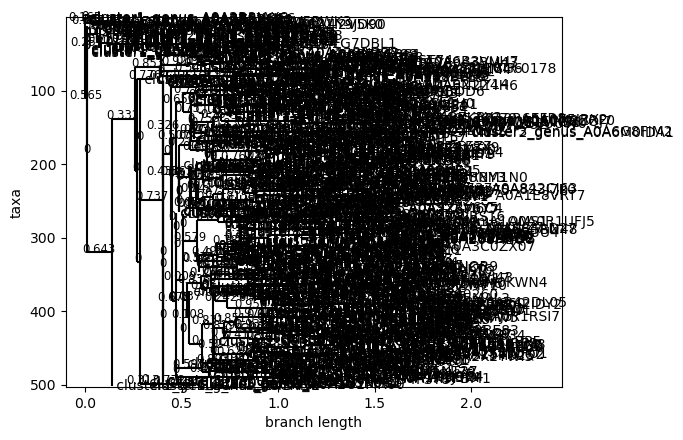